In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import missingno
import seaborn as sns

from tqdm import tqdm

tqdm.pandas()
# silence warnings
warnings.filterwarnings("ignore")

In [2]:
# setting some CONSTANTs
plt.style.use(['science'])
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",   # specify font family here
    "font.serif": ["Palatino"],  # specify font here
    "font.size":12})

CATEGORY = 'Grocery_and_Gourmet_Food'
FIGSIZE = (12, 8)

# Exploratory Data Analysis (EDA)

## 1. Data Exploration

### Loading Dataset

In [3]:
products = pd.read_csv(f"../data/interim/{CATEGORY}_merged.csv")

# check first 5 rows
products.head()

,asin,title,categories,reviewerID,overall,reviewText
0,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A23RYWDS884TUL,5.0,This curry paste makes a delicious curry. I j...
1,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A945RBQWGZXCK,5.0,I've purchased different curries in the grocer...
2,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A1TCSC0YWT82Q0,5.0,I love ethnic foods and to cook them. I recent...
3,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A3AMNY44OP8AOU,4.0,I started a new diet restricting all added sug...
4,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A3IB4CQ2QEJLJ8,5.0,So many flavors. I can't begin to tell you how...


### Descriptive Statistics

In [4]:
products.describe(include='all')

,asin,title,categories,reviewerID,overall,reviewText
count,77604,77604,77604,77604,77604.000000,77604
unique,4799,4738,610,14418,NaN,76472
top,B00934WBRO,"Grocery &amp; Gourmet Food"" />","['Grocery & Gourmet Food', 'Beverages', 'Coffe...",A2XKJ1KX6XUHYP,NaN,very good
freq,476,1064,5329,112,NaN,6
mean,NaN,NaN,NaN,NaN,4.255992,NaN
std,NaN,NaN,NaN,NaN,1.090522,NaN
min,NaN,NaN,NaN,NaN,1.000000,NaN
25%,NaN,NaN,NaN,NaN,4.000000,NaN
50%,NaN,NaN,NaN,NaN,5.000000,NaN
75%,NaN,NaN,NaN,NaN,5.000000,NaN


In [5]:
# summary statistics 
def summary_statistics(df):
    print(f"The dataframe consists of {df.shape[0]} rows and {df.shape[1]} columns")

    for col in df.columns:
        print(f"The number of unique {col}: {df[col].nunique()}")
        
summary_statistics(products)

The dataframe consists of 77604 rows and 6 columns
The number of unique asin: 4799
The number of unique title: 4738
The number of unique categories: 610
The number of unique reviewerID: 14418
The number of unique overall: 5
The number of unique reviewText: 76472


In [6]:
# create a temp category column based on first element and subsequently 2nd last element.
products['categories'] = products['categories'].progress_apply(lambda x: eval(x)[0][1])

100%|██████████| 77604/77604 [00:00<00:00, 99411.36it/s] 


### What is the rating globally and category-wise?

In [7]:
def product_ratings(df, agg="mean"):
    """Retrieving aggregrated review counts based on target group.

        Args:
            df [pd.DataFrame]:
            group [str]:
            agg [str]:
        Returns:
            reviews_by_group [pd.DataFrame]
    """

    rating_by_prod = df.groupby(["asin"]).agg({"overall": agg})
    rating_by_user = df.groupby(["reviewerID"]).agg({"overall": agg})

    # summary statistics
    print("==========")
    print(f"Global average ratings: {df['overall'].mean()}")
    print("For product rating:")
    print(
        f"Minimum rating for product: {rating_by_prod.min()[0]}, Maximum rating for products: {rating_by_prod.max()[0]}"
    )
    print(f"Average rating per products: {rating_by_prod.mean()[0]}")
    print(
        f"The interquartile range:\n{rating_by_prod['overall'].quantile([.25, 0.5, .75])}\n"
    )
    print("For user rating:")
    print(
        f"Minimum rating for users: {rating_by_user.min()[0]}, Maximum rating for users: {rating_by_user.max()[0]}"
    )
    print(f"Average rating per users: {rating_by_user.mean()[0]}")
    print(
        f"The interquartile range:\n{rating_by_user['overall'].quantile([.25, 0.5, .75])}\n"
    )

In [8]:
# rating average as a whole
product_ratings(products)

Global average ratings: 4.255991959177362
For product rating:
Minimum rating for product: 1.5, Maximum rating for products: 5.0
Average rating per products: 4.357911660151625
The interquartile range:
0.25    4.111111
0.50    4.428571
0.75    4.714286
Name: overall, dtype: float64

For user rating:
Minimum rating for users: 1.0, Maximum rating for users: 5.0
Average rating per users: 4.296102896804199
The interquartile range:
0.25    4.0
0.50    4.5
0.75    5.0
Name: overall, dtype: float64



In [9]:
# rating by categories
rating_by_cat = products.groupby(["categories"]).agg({"overall": 'mean'}).sort_values(by='overall', ascending=False)

print(f"Category-wise ratings:\n {rating_by_cat[:10]}")

Category-wise ratings:
              overall
categories          
r           4.255992


### What is the review count globally and category-wise?

In [10]:
def reviews_count(df, agg="count"):
    """Retrieving aggregrated review counts based on target group.

        Args:
            df [pd.DataFrame]:
            group [str]:
            agg [str]:
        Returns:
            reviews_by_group [pd.DataFrame]
    """

    reviews_by_prod = df.groupby(["asin"]).agg({"reviewText": agg})
    reviews_by_user = df.groupby(["reviewerID"]).agg({"reviewText": agg})

    # summary statistics
    print("==========")
    print(f"Global average ratings: {df['overall'].mean()}")
    print("For product reviews:")
    print(
        f"Minimum reviews for product: {reviews_by_prod.min()[0]}, Maximum reviews for products: {reviews_by_prod.max()[0]}"
    )
    print(f"Average reviews per products: {reviews_by_prod.mean()[0]}")
    print(
        f"The interquartile range:\n{reviews_by_prod['reviewText'].quantile([.25, 0.5, .75])}\n"
    )
    print("For user reviews:")
    print(
        f"Minimum reviews for users: {reviews_by_user.min()[0]}, Maximum reviews for users: {reviews_by_user.max()[0]}"
    )
    print(f"Average reviews per users: {reviews_by_user.mean()[0]}")
    print(
        f"The interquartile range:\n{reviews_by_user['reviewText'].quantile([.25, 0.5, .75])}\n"
    )

In [11]:
# review counts as whole
reviews_count(products)

Global average ratings: 4.255991959177362
For product reviews:
Minimum reviews for product: 4, Maximum reviews for products: 476
Average reviews per products: 16.170868931027297
The interquartile range:
0.25     6.0
0.50     8.0
0.75    14.0
Name: reviewText, dtype: float64

For user reviews:
Minimum reviews for users: 1, Maximum reviews for users: 112
Average reviews per users: 5.3824386183936745
The interquartile range:
0.25    3.0
0.50    4.0
0.75    6.0
Name: reviewText, dtype: float64



In [12]:
# reviews by categories
reviews_by_cat = products.groupby(["categories"]).agg({"reviewText": 'count'}).sort_values(by='reviewText', ascending=False)

print(f"Category-wise ratings:\n {reviews_by_cat[:10]}")

Category-wise ratings:
             reviewText
categories            
r                77604


## 2. Data Visualisation

In [13]:
# let's look at the average rating by products
def compute_mean_ratings(df, count_col, rating_col):
    """[summary]

    Args:
        df ([type]): [description]
        target_col ([type]): [description]
    """

    prod_mean_ratings = df.groupby(["asin"]).agg({rating_col: np.mean}).reset_index()
    prod_count_ratings = df.groupby(["asin"]).agg({count_col: "count"}).reset_index()
    prod_ratings_merged = pd.merge(
        prod_count_ratings, prod_mean_ratings, how="inner", on="asin"
    )

    prod_ratings_merged.columns = ["asin", "rating_counts", "rating_average"]

    return prod_ratings_merged

def compute_weighted_ratings(df, count_col, avg_rating_col, threshold=0.75):
    """Computes weighted ratings based on number of ratings and average rating.

        Args:
            df [pd.DataFrame]: DataFrame consisting both rating counts and average rating.
            count_col [str]: Column name for number of ratings.
            avg_rating_col [str]: Column name for average rating.
            threshold [float]: Threshold for minimum of ratings/reviews to qualify for ranking.
        Returns:
            df [pd.DataFrame]: DataFrame with newly computed weighted ratings
    """

    m = df[count_col].quantile(threshold)
    C = df[avg_rating_col].mean()  # global average rating

    df["rating_weighted_average"] = df.apply(
        lambda x: (
            (x[count_col] / (x[count_col] + m) * x[avg_rating_col])
            + (m / (m + x[count_col]) * C)
        ),
        axis=1,
    )

    return df

In [14]:
product_agg = compute_mean_ratings(products, 'reviewText', 'overall')
product_weighted_agg = compute_weighted_ratings(product_agg, 'rating_counts', 'rating_average', threshold=.75)

In [15]:
# check first 5 rows
product_weighted_agg.head()

,asin,rating_counts,rating_average,rating_weighted_average
0,9742356831,15,4.733333,4.552095
1,B00004S1C5,14,4.142857,4.250384
2,B00005344V,14,4.428571,4.393242
3,B0000CDEPD,10,4.600000,4.458782
4,B0000CFPI2,10,4.400000,4.375448


### What are top 25 top rated products?

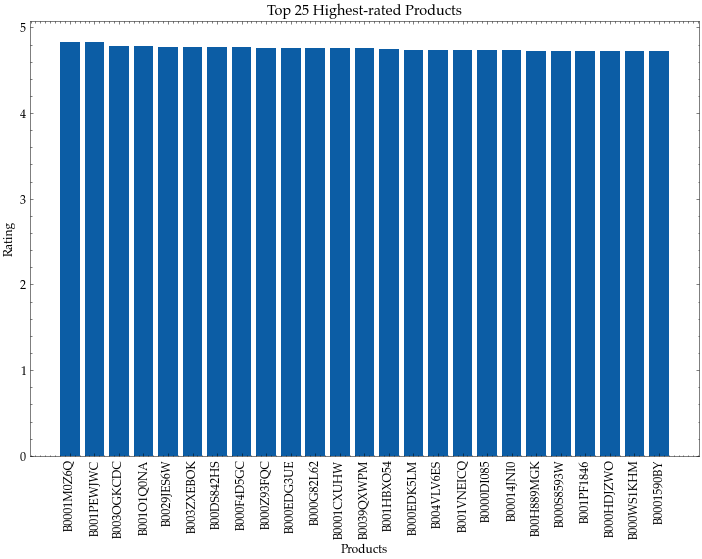

In [16]:
plt.figure(figsize=FIGSIZE)
plt.title("Top 25 Highest-rated Products")
plt.xlabel("Products")
plt.xticks(rotation=90)
plt.ylabel("Rating")

labels = product_agg.sort_values("rating_weighted_average", ascending=False)["asin"].values[:25]
values = product_agg.sort_values("rating_weighted_average", ascending=False)["rating_weighted_average"].values[:25]

plt.bar(labels, values)
plt.show()

### What are top 25 top reviewed products?

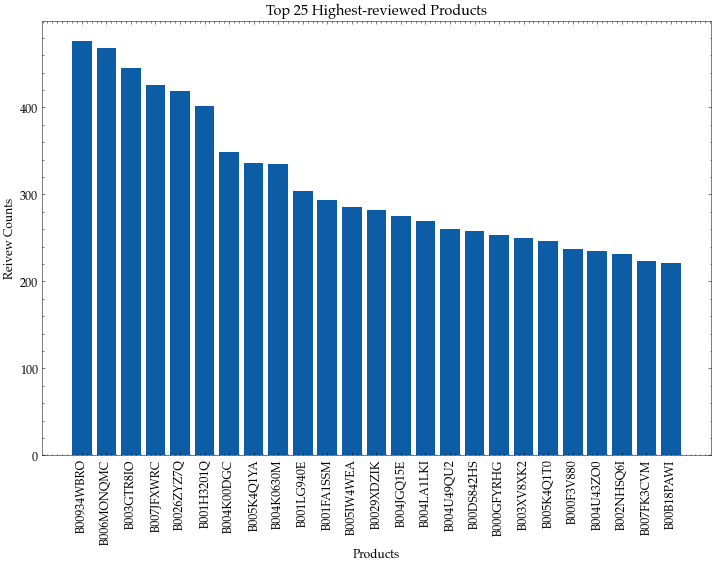

In [17]:
plt.figure(figsize=FIGSIZE)
plt.title("Top 25 Highest-reviewed Products")
plt.xlabel("Products")
plt.xticks(rotation=90)
plt.ylabel("Reivew Counts")

labels = product_agg.sort_values("rating_counts", ascending=False)["asin"].values[:25]
values = product_agg.sort_values("rating_counts", ascending=False)["rating_counts"].values[:25]

plt.bar(labels, values)
plt.show()

### What is the distribution of ratings by products?

In [18]:
def plot_ratings(df, cols=['rating_average', 'rating_weighted_average'], agg_by='products'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
    fig.suptitle(f"Average vs. Weighted Average Ratings by {agg_by.title()}", y=0.925, verticalalignment='bottom')
    for idx, col in enumerate(cols):
          sns.histplot(df[col], ax=axes[idx], bins=25)

    plt.savefig(f"../reports/figures/rating_distributions_by_{agg_by}.png")
    plt.show()

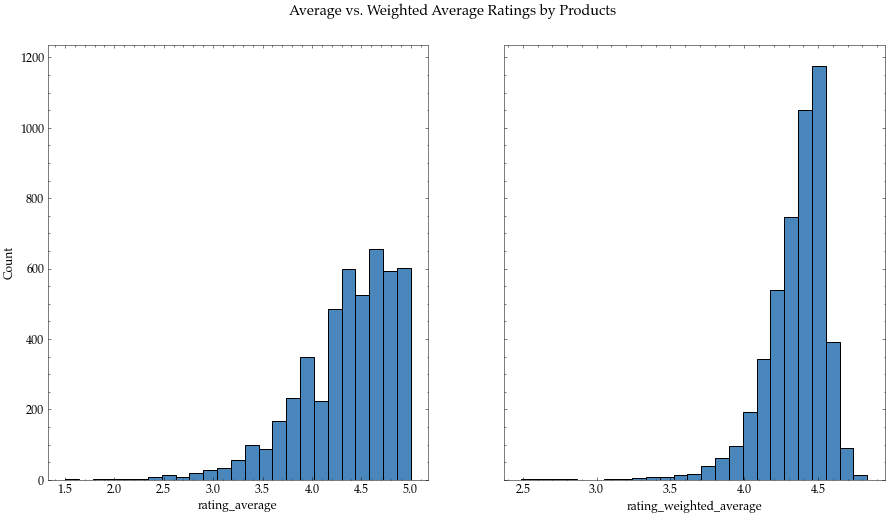

In [19]:
plot_ratings(product_weighted_agg)

### What is the distribution of ratings by users?

In [20]:
# let's look at the average rating by products
def compute_mean_ratings(df, count_col, rating_col):
    """[summary]

    Args:
        df ([type]): [description]
        target_col ([type]): [description]
    """

    prod_mean_ratings = df.groupby(["reviewerID"]).agg({rating_col: np.mean}).reset_index()
    prod_count_ratings = df.groupby(["reviewerID"]).agg({count_col: "count"}).reset_index()
    prod_ratings_merged = pd.merge(
        prod_count_ratings, prod_mean_ratings, how="inner", on="reviewerID"
    )

    prod_ratings_merged.columns = ["reviewerID", "rating_counts", "rating_average"]

    return prod_ratings_merged

def compute_weighted_ratings(df, count_col, avg_rating_col, threshold=0.75):
    """Computes weighted ratings based on number of ratings and average rating.

        Args:
            df [pd.DataFrame]: DataFrame consisting both rating counts and average rating.
            count_col [str]: Column name for number of ratings.
            avg_rating_col [str]: Column name for average rating.
            threshold [float]: Threshold for minimum of ratings/reviews to qualify for ranking.
        Returns:
            df [pd.DataFrame]: DataFrame with newly computed weighted ratings
    """

    m = df[count_col].quantile(threshold)
    C = df[avg_rating_col].mean()  # global average rating

    df["rating_weighted_average"] = df.apply(
        lambda x: (
            (x[count_col] / (x[count_col] + m) * x[avg_rating_col])
            + (m / (m + x[count_col]) * C)
        ),
        axis=1,
    )

    return df

In [21]:
user_agg = compute_mean_ratings(products, 'reviewText', 'overall')
user_weighted_agg = compute_weighted_ratings(user_agg, 'rating_counts', 'rating_average', threshold=.75)

In [22]:
user_weighted_agg.head()

,reviewerID,rating_counts,rating_average,rating_weighted_average
0,A00177463W0XWB16A9O05,4,4.000000,4.177662
1,A022899328A0QROR32DCT,3,2.666667,3.752957
2,A068255029AHTHDXZURNU,3,4.333333,4.308513
3,A06944662TFWOKKV4GJKX,2,5.000000,4.472077
4,A1004703RC79J9,2,4.500000,4.347077


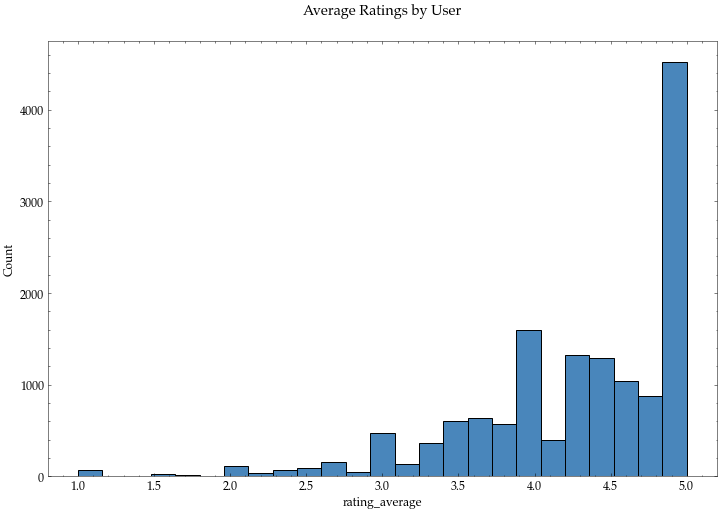

In [23]:
plt.figure(figsize=(12,8))
plt.title("Average Ratings by User", y=1.05)
sns.histplot(user_weighted_agg['rating_average'], bins=25)
plt.savefig(f"../reports/figures/rating_distributions_by_users.png")
plt.show()

In [24]:
pd.set_option('display.max_rows', 100)

In [25]:
products.sort_values(by='reviewText', key=lambda x: x.str.len())[500:600]

,asin,title,categories,reviewerID,overall,reviewText
59649,B005E8FTRC,Orville Redenbacher's Movie Theater Butter Pop...,r,A1J9Q4H5VJTQFP,4.0,Tasty popped corn from my microwave.... did n...
22764,B0017U48KK,Dr. McDougall's Right Foods Vegan Chicken Flav...,r,AC5G2FLJE3FW9,5.0,you can't get any easier than this for lunch a...
56337,B004VLSTN4,"Bob's Red Mill Organic Buckwheat Flour, 22-oun...",r,A1TZ5V3J0R8N3E,2.0,word of caution: this buckwheat flour is dark ...
1491,B0001FFHCK,"Amber Lyn Sugar-Free Dark Chocolate, 15-Count",r,ANSHESKJHI7YH,5.0,A W E S O M E! and guiltless to boot! I'm or...
71781,B00AR6NBU8,Rishi Tea Organic Pu-erh Classic Loose Leaf Te...,r,A1LEZ2R6RERVAB,5.0,Great tea. It's really enjoyable. I've seen so...
23075,B0019FOZC4,"DoMatcha - Organic Ceremonial Matcha Powder, N...",r,A2HPGXO4Q0S7VE,5.0,"Really great for lattes, however, it is to exp..."
18737,B000WR4LM4,Simply Organic Thyme Leaf Whole Certified Orga...,r,A3LR7SD5E733I3,5.0,I add this to all my cooking along with all my...
1498,B0001FFHCK,"Amber Lyn Sugar-Free Dark Chocolate, 15-Count",r,ANSHESKJHI7YH,5.0,A W E S O M E! and guiltless to boot! I'm or...
5246,B000E199VQ,Late July Organic Mini Cheddar Cheese Bite Siz...,r,AVDM0ICCRC5BD,5.0,The crackers are the best. Great for lunches o...
28760,B001EO5U3I,"Grocery &amp; Gourmet Food"" />",r,A18LN2FR7EHDYM,5.0,"Wish I could get in bigger quanty,SO I don't h..."


In [26]:
from gingerit.gingerit import GingerIt

In [27]:
parser = GingerIt()

In [28]:
line = 'nice and comf'

In [29]:
parser.parse(line)['result']

'nice and comfy'